In [5]:
import os
os.getcwd()
os.chdir('/work')
print(os.getcwd())
current_folder = globals()['_dh'][0]
import pathlib
import sys
del sys.argv[1]
print(sys.path)
from sty import fg, bg, rs, ef

from experiments.transformations.analysis.activation_distance.activation_distance_utils import *

/work
['/work/code/experiments/transformations/analysis/activation_distance', '/work/scripts', '/work/code', '/work/code/experiments/transformations/analysis/activation_distance', '/src', '/src/models', '/work/code/ML_framework', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/thedude/.ipython']


In [6]:
import sty
import framework_utils
from generate_datasets.generators.extension_generators import *
from torch.utils.data import DataLoader
import os
import torch.nn as nn
from experiments.transformations.transf_utils import classes_sets, exp_categorization_task, get_transforms, add_unpack_transf_info
from experiments.transformations.transf_exp import get_weighted_sampler, get_name_samples_file_train, get_name_samples_file_test
from torch.utils.data import DataLoader
from datasets import add_compute_stats
from experiments.transformations.transf_utils import classes_sets, exp_categorization_task
from experiments.transformations.utils.datasets import SubclassImageFolder, get_transforms

network_name = 'vgg11bn'
dataset_name = 'ShapeNet'
def get_exp(max_objs):
    shared_args = lambda: dict(seed=1, project_name='Transformations', use_weblog=0, batch_size=64, max_epochs=-1 if torch.cuda.is_available() else 2, num_viewpoints_train=1, use_mat=0, max_objs_per_class_train=max_objs)
    exp = exp_categorization_task(**shared_args(),
                                  classes_set='set2',
                                  network_name=network_name,
                                 use_device_num=3,
                                 verbose=False)

    name_folder = f'ShapeNet2DFull{"Nomat" if not exp.use_mat else ""}'
    
    add_PIL_transforms, add_T_transforms = get_transforms('', info=False)
    args = dict(name_generator=f"train {exp.classes_set}", add_PIL_transforms=add_PIL_transforms, add_tensor_transforms=add_T_transforms, save_stats_file=None, stats=stats, num_objects_per_class=exp.max_objs_per_class_train, name_classes=classes_sets[exp.classes_set], num_viewpoints_per_object=exp.num_viewpoints_train,root=f"./data/ShapeNet2D/{name_folder}/train", save_load_samples_filename=get_name_samples_file_train('train', exp))
    dataset = add_compute_stats(SubclassImageFolder)(**args)
    loader = DataLoader(dataset, batch_size=exp.batch_size, shuffle=False, num_workers=0, timeout=0, pin_memory=True)

    return exp, dataset, loader
    

In [7]:
stats = {'mean': [0.06229676, 0.0607271, 0.05646703], 'std': [0.14454809, 0.14061172, 0.12994126]}

def change_transformation_dataset(dataset, transformations):
    # num_v = 50 if 'v' in transformations else 1
    add_PIL_transforms, add_T_transforms = get_transforms(transformations, info=False)
    dataset.transform = torchvision.transforms.Compose([*add_PIL_transforms, torchvision.transforms.ToTensor(), *add_T_transforms])
    normalize = torchvision.transforms.Normalize(mean=stats['mean'],
                                                         std=stats['std'])
    dataset.transform.transforms += [normalize]


In [61]:
# pt = 'vanilla'
max_objs = 3
exp, dataset_no_transf, loader = get_exp(max_objs=max_objs)


Using cuda - you are probably on the server
Running experiment in SCRIPT mode. Command line arguments will have the precedence over keywords arguments.
Device Name: [GeForce RTX 3090] - Selected device num: 3

**LIST_TAGS**:
['ptvanilla', 'bkbnvanilla']
***PARAMS***
	add_cat_module : False
	additional_tags : None
	backbone_name : None
	batch_size : 64
	classes_set : set2
	device_name : GeForce RTX 3090
	diff_classes_set : None
	do_train : True
	force_cuda : None
	freeze_all_but_last : False
	freeze_backbone : False
	learning_rate : None
	max_epochs : -1
	max_iterations : -1
	max_objs_per_class_test : None
	max_objs_per_class_train : 3
	model_output_filename : None
	network_name : vgg11bn
	num_iterations_testing : -1
	num_runs : 1
	num_viewpoints_test : None
	num_viewpoints_train : 1
	output_filename : None
	patience_stagnation : -1
	pretraining : vanilla
	pretraining_backbone : vanilla
	project_name : Transformations
	scramble_fc : 0
	seed : 1
	stop_when_train_acc_is : -1
	transformati

In [62]:
from sklearn.neighbors import KNeighborsClassifier
import torch
def cossim_metric(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

neigh_cossim = KNeighborsClassifier(n_neighbors=1, metric=cossim_metric)
neigh_eucl = KNeighborsClassifier(n_neighbors=1)


In [87]:
def compute_knn_for_transformation(pt_transform, pt_objs, transformation, network_name, seed,  num_output_net=None):
    pt_num_v = 50 if 'v' in pt_transform else 1
    
    if pt_transform == 'vanilla':
        exp.pretraining = 'vanilla'
        exp.network_name = network_name
        output = 10
        net = exp.get_net(output)
        net_name = 'vanilla'
        folder_output = 'others'
        
    elif pt_transform == 'ImageNet':
        exp.network_name = 'vgg11bn'
        exp.pretraining = './models/ptImageNet/vgg11bn.pt'
        output = 1000
        net = exp.get_net(output)
        net_name = 'ImageNet'
        folder_output = 'others'
    else:
        if dataset == 'ShapeNet':
            net_name = f'FULLTRAIN_T{pt_transform}_objs{pt_objs}_vp{pt_num_v}_mat0_trset1_S{seed}'
        elif dataset == 'cifar10':
            net_name = f'FULLTRAIN_T{pt_transform}_imgs{pt_objs}_{network_name}_S{seed}'
        exp.network_name = network_name
        exp.pretraining = f'./models/transformations/{dataset}/{network_name}/{folder}/{net_name}.pt'
        folder_output = folder
        net = exp.get_net(10 if num_output_net is None else num_output_net)
    if network_name == 'relationNet':
        net = net.backbone
        features = torch.zeros(0, 512)

    else:
        net.classifier = nn.Sequential(*list(net.classifier.children())[:-3]) # before last classifier and dropout\n",
        features = torch.zeros(0, 4096)
    
    net.eval()
    net.cuda()
    print(net)
    ### Get all un-transformed objects
    print(sty.fg.red + f"Loading dataset from {loader.dataset.name_generator}" + sty.rs.fg)
    
    change_transformation_dataset(dataset_no_transf, transformation)
    print(loader.dataset.samples)
    y = torch.empty(0, dtype=int)
    for idx, data in enumerate(loader):
        img, lb, more = data
        lo = more['label_object']
        framework_utils.imshow_batch(img, stats=stats)
        #asd
        features = torch.vstack((features, net(img.cuda()).detach().cpu()))
        y = torch.hstack((y, lo))
    neigh_cossim.fit(features.detach().cpu().numpy(), y.detach().cpu().numpy())
    neigh_eucl.fit(features.detach().cpu().numpy(), y.detach().cpu().numpy())    
    ## Get activations for transformed objects
    print(neigh_cossim.get_params())
    print("DONE FITTINg")
    N_test = 5
    i = 0
    y = torch.empty(0, dtype=int)
    
    tot_count = 0
    p_eucl = []
    p_cossim = []
    while (i < N_test):
        print(f"Repetition {i}")
        for idx, data in enumerate(loader):
            if idx % 10 == 9:
                print(idx)

            img, lb, more = data
            lo = more['label_object']
            framework_utils.imshow_batch(img, stats=stats) #if tot_count == 0 else None
          #  plt.show()
            features = net(img.cuda())
            p_eucl.extend(neigh_eucl.predict(features.detach().cpu().numpy()))
            p_cossim.extend(neigh_cossim.predict(features.detach().cpu().numpy()))
            a, b =neigh_cossim.kneighbors(features.detach().cpu().numpy())
            print(b)
            #asd
    
            y = torch.hstack((y, lo))
            tot_count += 1
        i += 1
    
    acc_cossim = np.mean([i == j for i, j in zip(p_cossim, y.detach().numpy())])
    acc_euclid = np.mean([i == j for i, j in zip(p_eucl, y.detach().numpy())])
    print(f'Acc K-nn Cossim: {acc_cossim}')
    print(f'Acc K-nn Euclid: {acc_euclid}')

    output_path = f'./results/transformations/knn-test/{dataset_name}/{network_name}/{folder_output}/knn_T{transformation}_objs3_vp1_shapeNetSet2_{net_name}.pickle'
    print(fg.red + f"Saving result in {output_path}" + rs.fg)
    pathlib.Path(os.path.dirname(output_path)).mkdir(parents=True, exist_ok=True)

    pickle.dump({'acc_cossim': acc_cossim, 'acc_euclidean': acc_euclid}, open(output_path,'wb'))
    print(f'Prediction cossim {p_cossim} \nTrue values {y}')




VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

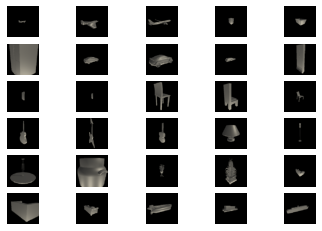

{'algorithm': 'auto', 'leaf_size': 30, 'metric': <function cossim_metric at 0x7f6a396c6c10>, 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
DONE FITTINg
Repetition 0
Tkinter can't maximize. Skipped


<Figure size 432x288 with 0 Axes>

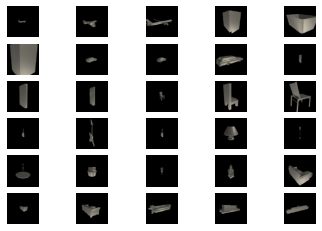

[[ 0]
 [ 1]
 [ 2]
 [12]
 [25]
 [ 5]
 [ 8]
 [ 8]
 [ 7]
 [10]
 [ 9]
 [17]
 [ 3]
 [13]
 [12]
 [10]
 [16]
 [10]
 [18]
 [11]
 [10]
 [24]
 [11]
 [17]
 [25]
 [ 3]
 [26]
 [27]
 [29]
 [29]]
Repetition 1
Tkinter can't maximize. Skipped


<Figure size 432x288 with 0 Axes>

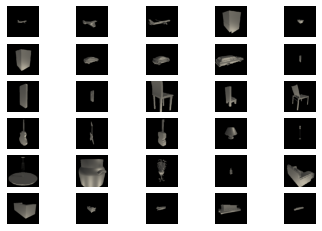

[[ 0]
 [ 1]
 [ 2]
 [12]
 [ 3]
 [23]
 [ 6]
 [ 6]
 [ 7]
 [11]
 [ 9]
 [10]
 [12]
 [15]
 [12]
 [15]
 [16]
 [15]
 [ 4]
 [19]
 [20]
 [21]
 [16]
 [10]
 [25]
 [25]
 [ 8]
 [ 8]
 [27]
 [ 0]]
Repetition 2
Tkinter can't maximize. Skipped


<Figure size 432x288 with 0 Axes>

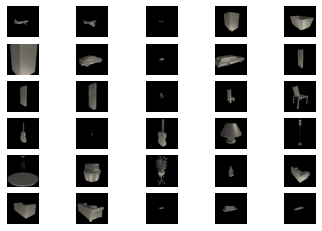

[[28]
 [ 1]
 [11]
 [23]
 [25]
 [ 5]
 [ 7]
 [11]
 [ 7]
 [17]
 [17]
 [ 9]
 [10]
 [24]
 [12]
 [17]
 [11]
 [15]
 [18]
 [19]
 [20]
 [23]
 [16]
 [24]
 [13]
 [25]
 [25]
 [11]
 [28]
 [ 0]]
Repetition 3
Tkinter can't maximize. Skipped


<Figure size 432x288 with 0 Axes>

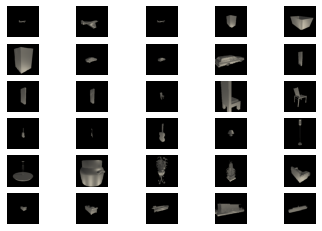

[[ 0]
 [ 1]
 [ 0]
 [26]
 [ 7]
 [12]
 [ 8]
 [ 0]
 [ 7]
 [22]
 [22]
 [22]
 [10]
 [13]
 [26]
 [10]
 [11]
 [17]
 [ 3]
 [19]
 [20]
 [21]
 [16]
 [15]
 [13]
 [10]
 [26]
 [28]
 [ 7]
 [29]]
Repetition 4
Tkinter can't maximize. Skipped


<Figure size 432x288 with 0 Axes>

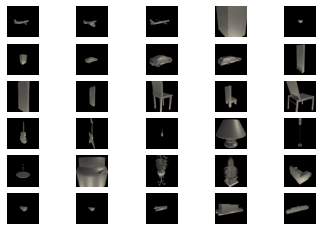

[[28]
 [ 1]
 [ 2]
 [ 5]
 [ 0]
 [24]
 [ 6]
 [ 7]
 [27]
 [ 9]
 [ 9]
 [17]
 [12]
 [13]
 [12]
 [15]
 [16]
 [11]
 [ 5]
 [19]
 [10]
 [21]
 [16]
 [23]
 [13]
 [ 3]
 [ 3]
 [ 8]
 [ 7]
 [29]]
Acc K-nn Cossim: 0.3333333333333333
Acc K-nn Euclid: 0.3333333333333333
Saving result in ./results/transformations/knn-test/ShapeNet/relationNet/others/knn_Ts_objs3_vp1_shapeNetSet2_vanilla.pickle
Prediction cossim [0, 1, 2, 12, 25, 5, 8, 8, 7, 10, 9, 17, 3, 13, 12, 10, 16, 10, 18, 11, 10, 24, 11, 17, 25, 3, 26, 27, 29, 29, 0, 1, 2, 12, 3, 23, 6, 6, 7, 11, 9, 10, 12, 15, 12, 15, 16, 15, 4, 19, 20, 21, 16, 10, 25, 25, 8, 8, 27, 0, 28, 1, 11, 23, 25, 5, 7, 11, 7, 17, 17, 9, 10, 24, 12, 17, 11, 15, 18, 19, 20, 23, 16, 24, 13, 25, 25, 11, 28, 0, 0, 1, 0, 26, 7, 12, 8, 0, 7, 22, 22, 22, 10, 13, 26, 10, 11, 17, 3, 19, 20, 21, 16, 15, 13, 10, 26, 28, 7, 29, 28, 1, 2, 5, 0, 24, 6, 7, 27, 9, 9, 17, 12, 13, 12, 15, 16, 11, 5, 19, 10, 21, 16, 23, 13, 3, 3, 8, 7, 29] 
True values tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 

<Figure size 432x288 with 0 Axes>

In [97]:

dataset='ShapeNet'
folder = 'fulltrain'
compute_knn_for_transformation(pt_transform='vanilla', pt_objs=100, transformation='s', network_name='relationNet', seed=1) 


In [91]:
compute_knn_for_transformation(pt_transform='vtrsbc', pt_objs=500, transformation='t')

TypeError: compute_knn_for_transformation() missing 2 required positional arguments: 'network_name' and 'seed'

NameError: name 'net' is not defined

In [34]:
# objs_list = [1]
# [compute_knn_for_transformation(pt_transform='ImageNet', pt_objs=objs, transformation='t') for objs in objs_list]
# [compute_knn_for_transformation(pt_transform='ImageNet', pt_objs=objs, transformation='r') for objs in objs_list]
# [compute_knn_for_transformation(pt_transform='ImageNet', pt_objs=objs, transformation='s') for objs in objs_list]


# [compute_knn_for_transformation(pt_transform='vanilla', pt_objs=objs, transformation='t') for objs in objs_list]
# [compute_knn_for_transformation(pt_transform='vanilla', pt_objs=objs, transformation='r') for objs in objs_list]
# [compute_knn_for_transformation(pt_transform='vanilla', pt_objs=objs, transformation='s') for objs in objs_list]

objs_list = [1, 5, 25, 50, 100, 250, 500]
[compute_knn_for_transformation(pt_transform='t', pt_objs=objs, transformation='t') for objs in objs_list]
[compute_knn_for_transformation(pt_transform='r', pt_objs=objs, transformation='r') for objs in objs_list]
[compute_knn_for_transformation(pt_transform='s', pt_objs=objs, transformation='s') for objs in objs_list]


Loading.. full model from ./models/transformations//ShapeNet/vgg11bn/fulltrain//FULLTRAIN_Tt_objs1_vp1_mat0_trset1.pt... Done.
Loading dataset from train set2
DONE FITTINg
Acc K-nn Cossim: 0.7
Acc K-nn Euclid: 0.5733333333333334
Saving result in ./results/transformations/knn-test/ShapeNet/vgg11bn/fulltrain/knn_Tt_objs3_vp1_shapeNetSet2_FULLTRAIN_Tt_objs1_vp1_mat0_trset1.pickle
Prediction cossim [4, 25, 29, 23, 1, 11, 22, 9, 5, 15, 19, 12, 17, 18, 28, 5, 2, 29, 11, 16, 5, 20, 24, 27, 12, 7, 6, 13, 27, 0, 7, 0, 9, 14, 8, 20, 13, 16, 23, 3, 28, 25, 11, 18, 28, 15, 10, 22, 29, 17, 3, 19, 4, 24, 3, 27, 2, 27, 28, 22, 12, 26, 22, 13, 15, 27, 17, 14, 8, 10, 27, 4, 28, 25, 5, 16, 11, 27, 7, 2, 2, 28, 19, 5, 9, 5, 19, 24, 23, 1, 24, 0, 5, 11, 24, 20, 27, 1, 14, 27, 14, 25, 9, 16, 28, 7, 28, 8, 2, 17, 16, 15, 10, 10, 19, 3, 4, 23, 7, 5, 14, 8, 15, 28, 24, 7, 23, 18, 10, 5, 27, 8, 19, 0, 2, 22, 13, 7, 19, 24, 25, 17, 16, 4, 18, 11, 11, 29, 3, 28] 
True values tensor([ 4, 25, 29, 23,  1, 11, 22,  

[None, None, None, None, None, None, None]

In [ ]:
y

In [ ]:
p_eucl

In [52]:
p_cossim

array([1, 1, 4, 3, 7, 7, 2, 1, 5, 2, 0, 9, 5, 0, 5, 0, 0, 7, 5, 7, 7, 8, 9, 8, 4, 5, 4, 1, 5, 1, 7, 3, 1, 9, 6, 9, 1, 1, 8, 4, 0, 7, 5, 5, 9, 4, 5, 5, 1, 0])